<a href="https://colab.research.google.com/github/Acme94/EDGAR/blob/main/%D0%9F%D1%80%D0%BE%D1%82%D0%BE%D1%82%D0%B8%D0%BF_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D1%81%D0%B5%D1%82%D0%B8_EDGAR_%D0%A0%D0%BE%D0%BC%D0%B0%D0%BD%D0%B5%D0%BD%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Тема, описание задачи

Электронная система сбора, анализа и поиска данных (EDGAR) представляет собой огромную открытую базу данных, содержащую информацию о публичных компаниях США. Эта база данных содержит обязательные заявки от публичных компаний США, такие как периодические заявки или заявки после важных изменений в компании. Все заявки в EDGAR отнесены к определенной категории. В этой работе используется EDGAR, потому что она содержит различные обязательные отчеты компаний. Еще одним преимуществом EDGAR является хорошее качество данных. Заявки должны иметь четкую определенную структуру и они должны быть официальными и написаны на хорошем английском языке. Это приводит лишь к нескольким опечаткам. Еще одним преимуществом EDGAR является его открытая доступность. Одной из целей EDGAR является сокращение инсайдерской торговли. В этой работе будут использоваться только заявки 8-K. Компании обычно предоставляют несколько 8-K в течение года всякий раз, когда происходят важные корпоративные события, которые требуют раскрытия информации. Компании должны подавать форму 8-K незамедлительно, а не ждать следующего периодического отчета, такого как квартальный отчет (по форме 10-Q) или годовой отчет (по форме 10-K). Компании обязаны раскрывать большую часть информации 8-K в течение четырех рабочих дней после инициирующего события, а в некоторых случаях даже раньше. Особенно эти заявки могут повлиять на цену акций компании. Анализировать эти документы людьми практически невозможно из-за огромного количества документов в EDGAR. Данные также распределены по многим документам. Это распределение усложняет автоматический анализ. 

## 2. База данных

Исторические данные по ценам акций

In [ ]:
import urllib.request, json , time, os, difflib, itertools
from multiprocessing.dummy import Pool
from datetime import datetime
import pandas as pd

try:
    import httplib
except:
    import http.client as httplib
    

def check_internet():
    conn = httplib.HTTPConnection("www.google.com", timeout=5)
    try:
        conn.request("HEAD", "/")
        conn.close()
        # print("True")
        return True
    except:
        conn.close()
        # print("False")
        return False


def get_historic_price(query_url, json_path, csv_path):
    while not check_internet():
        print("Could not connect, trying again in 5 seconds...")
        time.sleep(5)

    stock_id = query_url.split("&period")[0].split("symbol=")[1]

    if os.path.exists(csv_path + stock_id + '.csv') and os.stat(csv_path + stock_id + '.csv').st_size != 0:
        print("<<<  Historical data of " + stock_id + " already exists, Updating data...")

    try:
        with urllib.request.urlopen(query_url) as url:
            parsed = json.loads(url.read().decode())
    except:
        print("|||  Historical data of " + stock_id + " doesn't exist")
        return

    else:
        if os.path.exists(json_path + stock_id + '.json'):
            os.remove(json_path + stock_id + '.json')
        with open(json_path + stock_id + '.json', 'w') as outfile:
            json.dump(parsed, outfile, indent=4)

        try:
            Date = []
            for i in parsed['chart']['result'][0]['timestamp']:
                Date.append(datetime.utcfromtimestamp(int(i)).strftime('%d-%m-%Y'))            
            Close = parsed['chart']['result'][0]['indicators']['quote'][0]['close']            
            df = pd.DataFrame(list(zip(Date, Close)),columns = ['Date', 'Close'])
            if os.path.exists(csv_path + stock_id + '.csv'):
                os.remove(csv_path + stock_id + '.csv')
            df.to_csv(csv_path + stock_id + '.csv', sep=',', index=None)
            print(">>>  Historical data of " + stock_id + " saved")
            return
        except:
            print(">>>  Historical data of " + stock_id + " exists but has no trading data")

json_path = os.getcwd() + os.sep +  "json" + os.sep
csv_path = os.getcwd() + os.sep  + "csv" + os.sep


if not os.path.isdir(json_path):
    os.makedirs(json_path)
if not os.path.isdir(csv_path):
    os.makedirs(csv_path)

ticker_list = []
ticker_list.append('AAPL')
ticker_list.append('TSLA')
ticker_list.append('QS')
ticker_list.append('GME')
ticker_list.append('MSFT')
ticker_list.append('AMC')

query_urls=[]
for ticker in ticker_list:
    query_urls.append("https://query1.finance.yahoo.com/v8/finance/chart/"+ticker+"?symbol="+ticker+"&period1=0&period2=9999999999&interval=1d&includePrePost=true&events=div%2Csplit")

print(query_urls)

with Pool(processes=len(query_urls)) as pool:
    pool.starmap(get_historic_price, zip(query_urls, itertools.repeat(json_path), itertools.repeat(csv_path)))
print("All downloads completed !")

Отчеты 8-K

In [ ]:
from secedgar import filings, FilingType


def get_8k(ticker):
    my_filings = filings(cik_lookup=ticker,
                         filing_type=FilingType.FILING_8K,
                         user_agent="Your name (your email)",
                         start_date='20220101')
    my_filings.save('/historic_data/8k/')

ticker_list = []
ticker_list.append('AAPL')
ticker_list.append('TSLA')
ticker_list.append('QS')
ticker_list.append('GME')
ticker_list.append('MSFT')
ticker_list.append('AMC')
ticker_list.append('MBT')

for ticker in ticker_list:
    get_8k(ticker)

## 3. Параметризация данных

Подробное описание всех функций приведу в презентации.

In [ ]:
import re
from nltk.stem import PorterStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
import pandas as pd
import os


def get_99(path):
    with open(path, 'rt') as f:
        lines = f.readlines()
    try:
        lines2 = lines[lines.index("<TYPE>EX-99.1\n"):]
    except:
        return 0
    return lines2[:lines2.index('</TEXT>\n')]  # list type


def clear_99(lines):
    return re.sub(r'<[^>]+>|&#[0-9]+;|,|\.', r' ', str(lines), flags=re.M)


def stem_99(cleared_lines):
    ps = PorterStemmer()
    stemmed_report = []
    for word in cleared_lines.split():
        stemmed_report.append(ps.stem(word))
    return stemmed_report


def get_date(rep_path):
    with open(rep_path, 'rt') as f:
        header = ''
        header += f.readline()
        while re.search('<SEC-HEADER>', header) == None:
            header += f.readline()
        date0 = re.search('<SEC-HEADER>', header).string[-9:-1]
        date1 = date0[6:8] + '-' + date0[4:6] + '-' + date0[0:4]
    return date1


def get_rep_scoring(path):
    pos_terms = []
    neg_terms = []
    all_terms = []
    with open('pos_terms.txt', 'r') as f:
        for par in f:
            for w in par.split():
                pos_terms.append(w)
                all_terms.append(w)
    with open('neg_terms.txt', 'r') as f:
        for par in f:
            for w in par.split():
                neg_terms.append(w)
                all_terms.append(w)
    tokenizer = Tokenizer(num_words=1000, filters='!"#%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True,
                          split=' ', oov_token='unknown', char_level=False)
    tokenizer.fit_on_texts(all_terms)  # "Скармливаем" наши тексты, т.е. даём в обработку методу, который соберет словарь частотности
    items = list(tokenizer.word_index.items())  # Вытаскиваем индексы слов для просмотра
    reportWordIndexes = tokenizer.texts_to_sequences(stem_99(clear_99(get_99(path))))    
    pos_value = 0
    neg_value = 0
    for ind in reportWordIndexes:
        try:
            if ind[0] >= 132:
                neg_value += 1
            elif ind[0] > 1:
                pos_value += 1
            else:
                pass
        except:
            pass
    return get_date(path), pos_value, neg_value


# запись в файл
def rep_scores_to_csv(folder_path):
    rep_scores = []
    for item in os.listdir(folder_path):
        if get_rep_scoring(folder_path + item)[-1] != 0:
            rep_scores.append(get_rep_scoring(folder_path + item))
    df = pd.DataFrame(rep_scores,columns=['date','pos','neg'])
    output_filename = folder_path.split('/')[1] + ' scoring files'
    df.to_csv(output_filename + '.csv')
    return


rep_scores_to_csv('8k/TSLA/8-K/')

Подготовка данных для нейросети

## 4. Архитектура нейросети

In [ ]:
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from tensorflow.keras.optimizers import Adam #Оптимизатор
import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики


history = pd.read_csv('historical_csv/TSLA.csv')
history = pd.DataFrame(history['Close'].values,index=history['Date'])

scoring = pd.read_csv('TSLA scoring files.csv')
scoring = scoring.iloc[:,1:]
scoring.sort_values(by=['date'])

prev_date = ''
prev_close = 0
deltas = []
for scoring_date in scoring['date']:
    try:
        history.loc[scoring_date].values
    except:
        continue
    if prev_date != '':
        for close in history[prev_date:scoring_date].values:
            deltas.append([prev_date,float(close-prev_close),float(abs(close-prev_close))])
    prev_date = scoring_date
    prev_close = history.loc[scoring_date].values

deltas2 = []
date = deltas[0][0]
max_abs_delta = 0.0
sign = 0.0
for i in range(len(deltas)):
    if date != deltas[i][0]:
        date = deltas[i][0]
        if sign <= 0:
            max_abs_delta = -max_abs_delta
        #print(date,max_abs_delta)
        deltas2.append([date,max_abs_delta])
        max_abs_delta = 0.0
    if deltas[i][2] > max_abs_delta:
        max_abs_delta = deltas[i][2]
        sign = deltas[i][1]

deltas3 = pd.DataFrame(deltas2,columns=['date','max_delta'])

data = scoring.merge(deltas3,left_on='date',right_on='date')

x_train = np.array(data[['pos','neg']])
xScaler = MinMaxScaler()
xScaler.fit(x_train)
x_train = xScaler.transform(x_train)

y_train = np.array(data['max_delta'])
y_train = np.reshape(y_train,(-1,1))
yScaler = MinMaxScaler()
yScaler.fit(y_train)
y_train = yScaler.transform(y_train)

model = Sequential() # Создаём сеть прямого распространения
model.add(Dense(800, input_dim=2, activation="relu")) # Добавляем полносвязный слой на 800 нейронов с relu-активацией
model.add(Dense(400, activation="relu")) # Добавляем полносвязный слой на 400 нейронов с relu-активацией
model.add(Dense(1, activation="linear"))
model.compile(loss="mse", optimizer=Adam(lr=1e-4))
model.fit(x_train, y_train, batch_size=2, epochs=10, validation_split=0.2, verbose=1)

## 5. Графическое подтверждение

Данных для одной компании немного, поэтому обучение идет очень быстро.

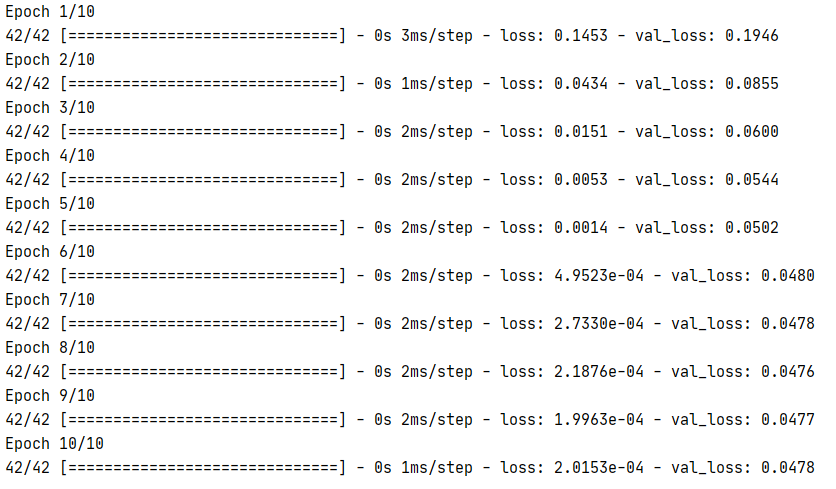

## 6. Ноутбуки

Приведены.

## 7, 8. Выводы и план дальнейшей работы

На примере такой "дутой" компании, как Тесла, выводы не сделать. В финальной версии попробую для разных компаний, плюс есть некоторые мысли по поводу обработки отчета, там большое поле для экспериментов.